<h1 style="font-size:300%">HOUSE PRICE PREDICTOR</h1>

This notebook is a starting point for a regression model that predicts house prices based on features of those houses. It uses the Boston House price dataset which is included in this repo as a csv file and represents prices of houses in the city of Boston in the 1970s. The data for this example is included in the git repo, so you can just clone this repo and run the notebook.

Bas S.H.T. Michielsen, 2025

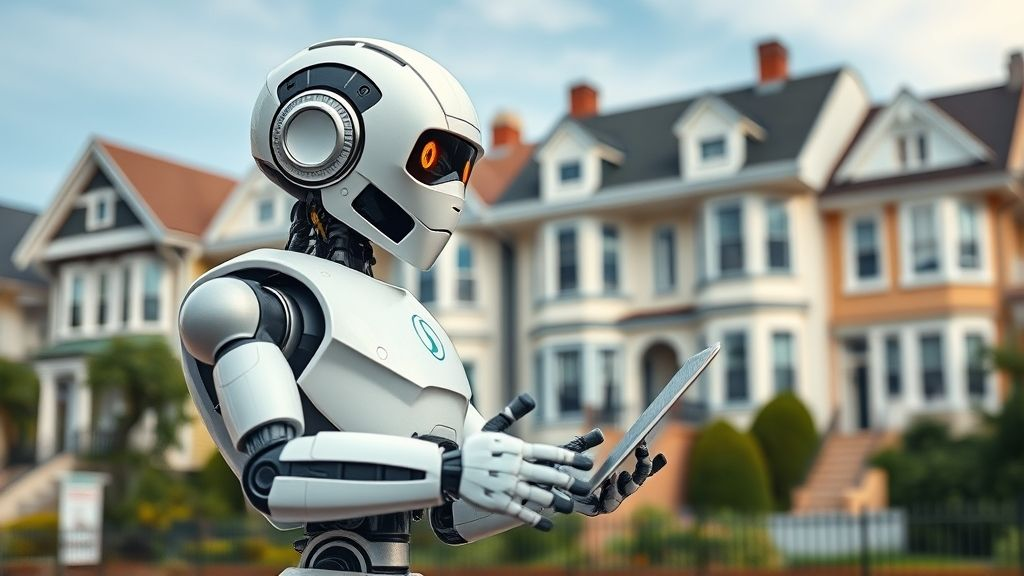

Image by Stable Diffusion: a robot selling houses in Boston

In [12]:
import csv, pandas, platform, os, seaborn, torch
import lightning as L
import torch.utils.data as D
import torchmetrics as M

data_path = "BostonHousing.csv"
torch.manual_seed(0)

print("Versions: python", platform.python_version(), "| torch", torch.__version__, "| lightning", L.__version__)

Versions: python 3.12.10 | torch 2.7.0+cpu | lightning 2.5.1.post0


# Create a Dataset

The first thing to do is create a torch Dataset object from the provided csv file. Here we use pandas to load the csv file into a DataFrame and then that DataFrame is used to put the data in a TensorDataset. A TensorDataset is a structure that contains a tensor of values as features and a tensor of values as target. Of our data the last column is the target and all the other columns are the features.

In [13]:
class TabularDataset(D.TensorDataset):
    """TabularDataSet loads data from a pandas DataFrame assuming the last column is the target and all other columns are features that can be converted to float."""
    def __init__(self, dataframe: pandas.DataFrame):
        rows = dataframe.values.astype(float)
        data = torch.tensor(rows, dtype=torch.float32)
        super().__init__(data[:, :-1], data[:, -1])
    
    def num_features(self) -> int:
        return self[0][0].size()[0]

df = pandas.read_csv(data_path)
dataset = TabularDataset(df)
print("Created a TabularDataset with", dataset.num_features(), "features.")

Created a TabularDataset with 13 features.


# Sample the data

We can now use the created DataFrame to sample the data. The last column, `medv` is the target and represents the price of the house in $1000. All other columns are used as features to predict `medv` with.

In [14]:
df.sample(5)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
59,0.10328,25.0,5.13,0,0.4530,5.927,47.2,6.9320,8,284,19.7,396.90,9.22,19.6
11,0.11747,12.5,7.87,0,0.5240,6.009,82.9,6.2267,5,311,15.2,396.90,13.27,18.9
277,0.06127,40.0,6.41,1,0.4470,6.826,27.6,4.8628,4,254,17.6,393.45,4.16,33.1
359,4.26131,0.0,18.10,0,0.7700,6.112,81.3,2.5091,24,666,20.2,390.74,12.67,22.6
282,0.06129,20.0,3.33,1,0.4429,7.645,49.7,5.2119,5,216,14.9,377.07,3.01,46.0


# Splitting the Dataset
To train a model, different dataset are needed, first there should be data for training purposes. However, to judge how well the model is fitted we also need data for validation and later for testing purposes. It is a common approach to split the dataset in three parts named `train`, `val` and `test` often in way that a resonably sized validation set and test set are created and the remaining data becoming the train set. For PyTorch Lightning, these three sets are then put together in something called a DataModule.

Note that you can increase `batch_size` or `num_workers` to speed up the process if you find that running this notebook is slow on your computer. However, doing so requires more CPU cores and/or more RAM so at some point you may reach a limit and things may break. The provided values of `batch_size=32` and `num_workers=0` is a safe default that is unlikely to produce errors.

In [4]:
train, val, test = D.random_split(dataset, [.6, .3, .1])
datamodule = L.LightningDataModule.from_datasets(train, val, test, batch_size=32, num_workers=0)
print("Created a DataModule with:", len(datamodule.train_dataloader().dataset), "training items,", len(datamodule.val_dataloader().dataset), "validation items and", len(datamodule.test_dataloader().dataset), "test items.")

Created a DataModule with: 304 training items, 152 validation items and 50 test items.


# Defining the Model
Of course there are many ways to define the model that is going to be trained. This example, though perhaps not the best model in the world, is rather simple and serves as an easy way of getting started with PyTorch Lightning. Here we create a simple feedforward neural network. The model consists of two layers defined in a sequential manner. First, we have a linear layer that takes in the features and transforms them into 64 nodes. This is followed by a ReLU (Rectified Linear Unit) activation function, which introduces non-linearity to the model, allowing it to learn more complex patterns. Finally, the output layer reduces the 64 nodes down to a single output, making this model suitable for regression tasks where we want to predict a continuous value. 

In [5]:
from torch import nn

class RegressionModel(L.LightningModule):
    def __init__(self, num_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        self.criterion = nn.MSELoss()
        self.r2 = M.R2Score()

    def forward(self, x):
        return self.model(x).view(-1)

    def training_step(self, batch):
        x, truth = batch
        out = self(x)
        return self.criterion(out, truth)
    
    def validation_step(self, batch):
        x, truth = batch
        out = self(x)
        loss = self.criterion(out, truth)
        self.log("val_loss", loss)

    def test_step(self, batch):
        x, y = batch
        out = self(x)
        self.log("test_r2", self.r2(out, y), on_step=False, on_epoch=True)

    def predict_step(self, batch):
        x, y = batch
        return self(x)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

model = RegressionModel(num_features=dataset.num_features())

# Training
Here we use a PyTorch Lightning Trainer to fit the model using the DataModule that we defined earlier. Internally it will iterate epochs, meaning that it will go through all train data to learn about relationships between the features and the target and then run a validation to gauge its performance which is measured in validation loss, meaning the difference between the true values and the model's predicted values. Here the assumption is that if the validation loss does no longer go down, the model is fitted as best as possible and continue training makes no improvements. We define an EarlyStopping for this that monitors when `val_loss` reaches its minimum. If so, it stops training.

In [6]:
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import EarlyStopping

logger = CSVLogger(save_dir=".")
stop = EarlyStopping(monitor="val_loss", mode="min")
trainer = L.Trainer(logger=logger, max_epochs=-1, callbacks=[stop], log_every_n_steps=10)
trainer.fit(model, datamodule=datamodule)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | model     | Sequential | 961    | train
1 | criterion | MSELoss    | 0      | train
2 | r2        | R2Score    | 0      | train
-------------------------------------------------
961       Trainable params
0         Non-trainable params
961       Total params
0.004     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


c:\Users\Bas\AppData\Local\Programs\Python\Python312-arm64\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\Bas\AppData\Local\Programs\Python\Python312-arm64\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\Bas\AppData\Local\Programs\Python\Python312-arm64\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 108: 100%|██████████| 10/10 [00:00<00:00, 87.35it/s, v_num=1] 


# Evaluation
Now that the model finished training, let's evaluate it. First we can plot the logged valiation loss and see that it has reached its minimum.

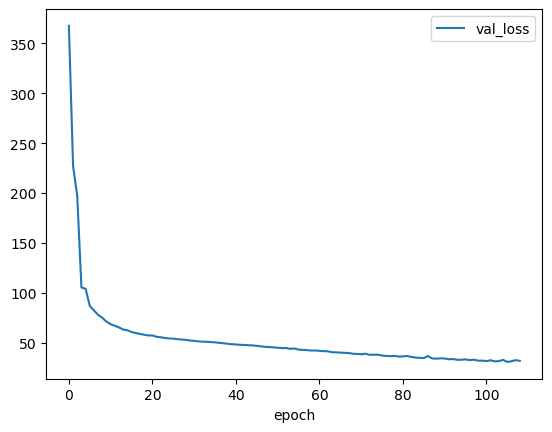

In [7]:
metrics = pandas.read_csv(os.path.join(trainer.log_dir, "metrics.csv"))
plot = metrics[["epoch", "val_loss"]].set_index("epoch").plot()

Now let's run the model against the test data and get an indication for how well it is performing. A typical metric for regression models is R-squared which is the proportion of the variation in the target that is predictable from the features. In other words, how well can the target be predicted using the features. An R-squared closer to 0.0 is worse and closer to 1.0 is better.

In [8]:
score = trainer.test(model, datamodule=datamodule)

c:\Users\Bas\AppData\Local\Programs\Python\Python312-arm64\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\Bas\AppData\Local\Programs\Python\Python312-arm64\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 154.86it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_r2            0.6255152821540833
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


A regplot shows how well the predictions of the model align with the truth values. Dots on or close ot the line are good predictions whereas if dots are scatterd away from the line it indicates that our model is not doing well. The shaded area represents the expected confidence interval and dots within the shaded area are considered close to the line. Morever, this plot shows that our model does reasonably well for houses priced between 15000 and 30000 but does a bit less good for houses that are more expensive or cheaper, as dots appear farther away from the line in those price ranges.

c:\Users\Bas\AppData\Local\Programs\Python\Python312-arm64\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 396.25it/s]


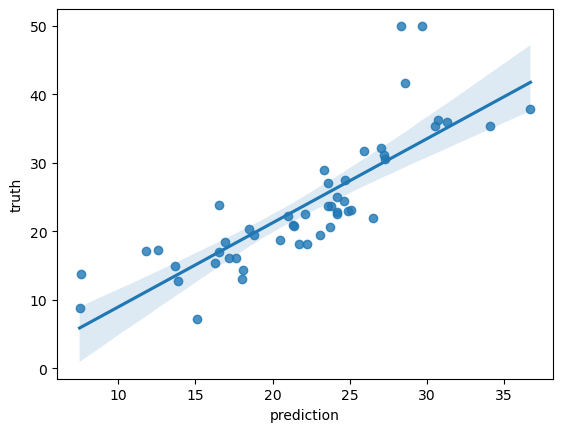

In [9]:
dataloader = datamodule.test_dataloader()
output = trainer.predict(model, dataloaders=dataloader)
predictions = torch.cat(output)
results = [[round(truth[1].item(),1), round(prediction.item(),1)] for truth, prediction in zip(dataloader.dataset, predictions)]
df = pandas.DataFrame(results, columns=["truth", "prediction"])
plot = seaborn.regplot(data=df, y="truth", x="prediction")

Here we print out all truth values, predicted values and the error (absolute difference between them) for every item in the test data.

In [10]:
df["error"] = abs(df["truth"] - df["prediction"])
df

,truth,prediction,error
0,18.5,16.9,1.6
1,27.1,23.6,3.5
2,22.6,22.1,0.5
3,14.3,18.1,3.8
4,25.0,24.2,0.8
5,17.2,11.8,5.4
6,21.0,21.3,0.3
7,18.2,22.2,4.0
8,23.1,25.1,2.0
9,16.1,17.6,1.5
